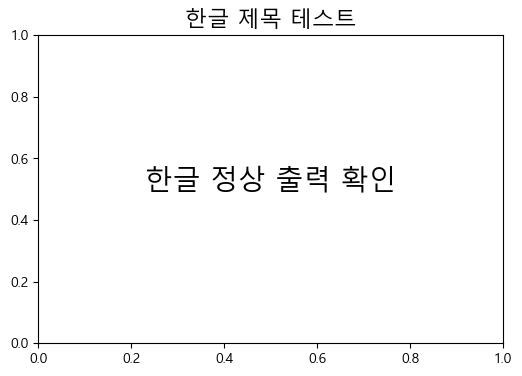

In [19]:
# 3. 한글 폰트 설정
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.rc('font', family='Malgun Gothic')
# 4. 테스트
plt.figure(figsize=(6, 4))
plt.text(0.5, 0.5, '한글 정상 출력 확인', fontsize=20, ha='center')
plt.title("한글 제목 테스트", fontsize=16)
plt.show()

## 데이터 불러오기
```final_season_added.csv``` 파일의 저장위치를 파악하고 불러온다

In [20]:
import pandas as pd
df = pd.read_csv(r"C:\Users\User\Documents\카카오톡 받은 파일\final_season_added.csv")

## 필요없다고 생각되거나 중복되는 내용의 object type 컬럼 제거
- ```전월세구분``` => 전세 | 월세 구분 컬럼
- ```계약일```,```geometry```,```종료월```,```계약년```,```시작연```,```시작월```,```종료연```, ```위도```,```경도``` => 필요없다고 판다
- ```구```, ```동```,```동별```,```행정동```, ```법정동``` => 중복 혹은 ```법정동코드```, ```자치구코드```로 대체가능

In [21]:
df = df.drop([
    '전월세구분','계약일','도로명','구','동','계약년','시작연','시작월','종료연','종료월','위도','경도','geometry','행정동','동별','건물명','법정동'
],axis=1)

##  ```object type```의 변수는 encoding 진행
### ```주택유형_encoded``` => 0은 아파트 1은 연립다세대
### ```계절``` => ```계절_겨울```, ```계절_봄```, ```계절_여름``` 컬럼 생성

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['주택유형_encoded'] = le.fit_transform(df['주택유형'])
df = pd.get_dummies(df, columns=['계절'], prefix='계절', drop_first=True)
df = df.drop(['주택유형'],axis=1)

## 타겟으로 설정할 ```['보증금(만원)', '월세금(만원)', '월부담액', '보증금/월세금', '월세금/면적']``` 컬럼들의 값을 standard scaler를 사용할 것인지





In [23]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# 스케일링할 타겟 후보 컬럼 리스트
target_cols = ['보증금(만원)', '월세금(만원)', '월부담액', '보증금/월세금', '월세금/면적']

# 1. 스케일러 선택 (MinMaxScaler or StandardScaler)
scaler = StandardScaler()

# 2. 해당 컬럼들만 스케일링
scaled_values = scaler.fit_transform(df[target_cols])

# 3. 스케일된 결과를 데이터프레임으로 변환 (컬럼명 유지)
df_scaled = pd.DataFrame(scaled_values, columns=target_cols)

# 4. 원본 데이터에서 해당 컬럼들 제거 후 스케일된 컬럼으로 대체
df.drop(columns=target_cols, inplace=True)
df = pd.concat([df, df_scaled], axis=1)

## 테스트 파이프라인 함수 생성
## train_eval_xgb함수

## ```train_eval_xgb``` 함수가 하는 것
데이터를 train_test_split으로 나누고 train 셋에 대해 XGBRegressor모델을 생성하고, test 셋에 대해 RMSE, MAE, R^2값을 반환하고, 모델의 feature importance 그래프와 shap 그래프를 반환 가능하고 그래프는 True, False로 선택가능하다
### 파라미터
- ```df```
- ``` target_col```
- ```test_size```
- ```random_state```
- ``` plot_feature_importance```(bool)
- ```plot_shap```(bool)
### return
- ```model, (X_train, X_test, y_train, y_test)```      
---------

(ex)
```python
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['월부담액','보증금/월세금','월세금/면적','보증금(만원)'],axis=1),'월세금(만원)', plot_feature_importance=False, plot_shap=False)
```
\>>> df.drop(['월부담액','보증금/월세금','월세금/면적','보증금(만원)'],axis=1)데이터를 바탕으로 모델을 구성하고 ```'월세금(만원)'```을 타겟으로 선정, 두개 그래프 모두 그리지 않는다


## (주의) !!!
```['보증금(만원)', '월세금(만원)', '월부담액', '보증금/월세금', '월세금/면적']``` 컬럼들은 보증금과 월세금의 정보가 포함된 값이므로 이중 하나만 데이터프레임에 포함되어야 한다

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import shap
import xgboost as xgb  # xgboost 임포트

def train_eval_xgb(df, target_col, test_size=0.2, random_state=42, plot_feature_importance=True, plot_shap=True):
    """
    df: pandas DataFrame (feature + target)
    target_col: 목표 변수 컬럼명 (문자열)
    test_size: 테스트 데이터 비율 (default 0.2)
    random_state: 시드값 (default 42)
    plot_feature_importance: feature importance 그래프 출력 여부
    plot_shap: shap summary plot 출력 여부

    반환값: 학습된 모델, (X_train, X_test, y_train, y_test) 튜플
    """

    # 1. 입력 데이터 분리
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 숫자형 피처만 선택 (필요하면 수정 가능)
    X = X.select_dtypes(include=[np.number])

    # 2. train/test 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # 3. XGBoost 회귀 모델 학습
    model = xgb.XGBRegressor(random_state=random_state, verbosity=0)
    model.fit(X_train, y_train)

    # 4. 예측 및 평가
    y_pred = model.predict(X_test)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test RMSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R^2: {r2:.4f}")

    # 5. Feature importance 시각화
    if plot_feature_importance:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices], align="center")
        plt.xticks(range(len(importances)), X.columns[indices], rotation=90)
        plt.tight_layout()
        plt.show()

    # 6. SHAP 값 계산 및 시각화
    if plot_shap:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)

        plt.figure()
        shap.summary_plot(shap_values, X_test, plot_type="bar")

        plt.figure()
        shap.summary_plot(shap_values, X_test)

    return model, (X_train, X_test, y_train, y_test)

## 타겟 변수 선택

In [25]:
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['월부담액','보증금/월세금','월세금/면적','보증금(만원)'],axis=1),'월세금(만원)',plot_feature_importance=False,plot_shap=False)
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['월부담액','보증금/월세금','월세금/면적','월세금(만원)'],axis=1),'보증금(만원)',plot_feature_importance=False,plot_shap=False)
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['월부담액','월세금/면적','월세금(만원)','보증금(만원)'],axis=1),'보증금/월세금',plot_feature_importance=False,plot_shap=False)
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['월부담액','보증금/월세금','월세금(만원)','보증금(만원)'],axis=1),'월세금/면적',plot_feature_importance=False,plot_shap=False)
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)'],axis=1),'월부담액',plot_feature_importance=False,plot_shap=False)

Test RMSE: 0.5140
Test MAE: 0.3277
Test R^2: 0.7387
Test RMSE: 0.6020
Test MAE: 0.3913
Test R^2: 0.6498
Test RMSE: 0.8157
Test MAE: 0.4277
Test R^2: 0.3830
Test RMSE: 0.7959
Test MAE: 0.3951
Test R^2: 0.3462
Test RMSE: 0.2893
Test MAE: 0.1652
Test R^2: 0.9173


## 성능평가

Test RMSE: 0.2893
Test MAE: 0.1652
Test R^2: 0.9173


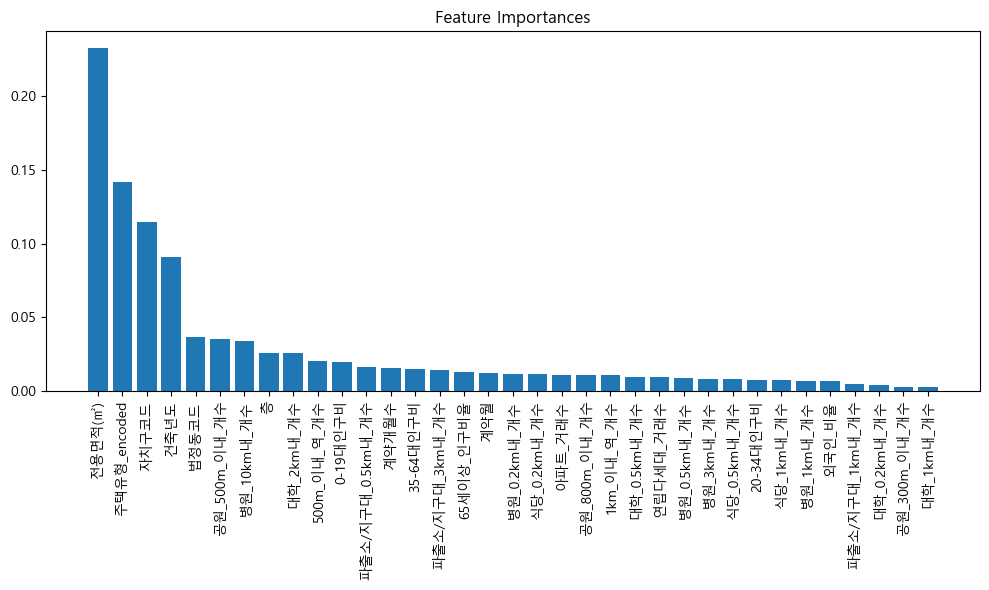

In [26]:
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)'],axis=1),'월부담액',plot_feature_importance=True,plot_shap=False)

아파트와 연립 다세대를 구분하여 테스트할경우 df_type0, df_type1데이터를 만든 이후 ```주택유형_encoded```컬럼도 지운다

## 아파트 or 연립다세대로 구분하여 df_type0와 df_type1데이터 생성

In [27]:
df_type0 = df[df['주택유형_encoded']==0] #아파트
df_type1 = df[df['주택유형_encoded']!=0] #연립다세대

Test RMSE: 0.3346
Test MAE: 0.1997
Test R^2: 0.9296


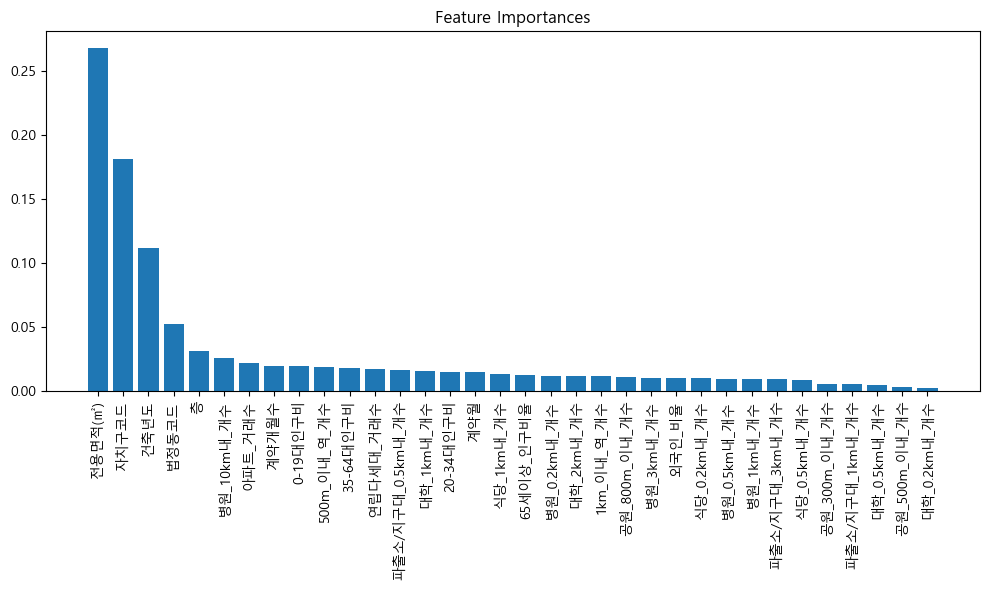

In [28]:

# 아파트 모든 유형별 각 거리를 다 넣어봄
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df_type0.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)','주택유형_encoded',],axis=1),'월부담액',plot_feature_importance=True,plot_shap=False)

In [29]:
hospital_group = ['병원_10km내_개수', '병원_3km내_개수','병원_0.5km내_개수','병원_1km내_개수','병원_0.2km내_개수']
station_group = ['500m_이내_역_개수', '1km_이내_역_개수']
restaurant_group = ['식당_0.2km내_개수','식당_0.5km내_개수','식당_1km내_개수']
park_group = ['공원_300m_이내_개수','공원_500m_이내_개수','공원_800m_이내_개수']
police_group = ['파출소/지구대_0.5km내_개수','파출소/지구대_1km내_개수','파출소/지구대_3km내_개수']
university_group = ['대학_0.2km내_개수','대학_0.5km내_개수','대학_1km내_개수','대학_2km내_개수']
group_features = hospital_group + station_group + restaurant_group + park_group + police_group + university_group

Test RMSE: 0.3266
Test MAE: 0.1947
Test R^2: 0.9329


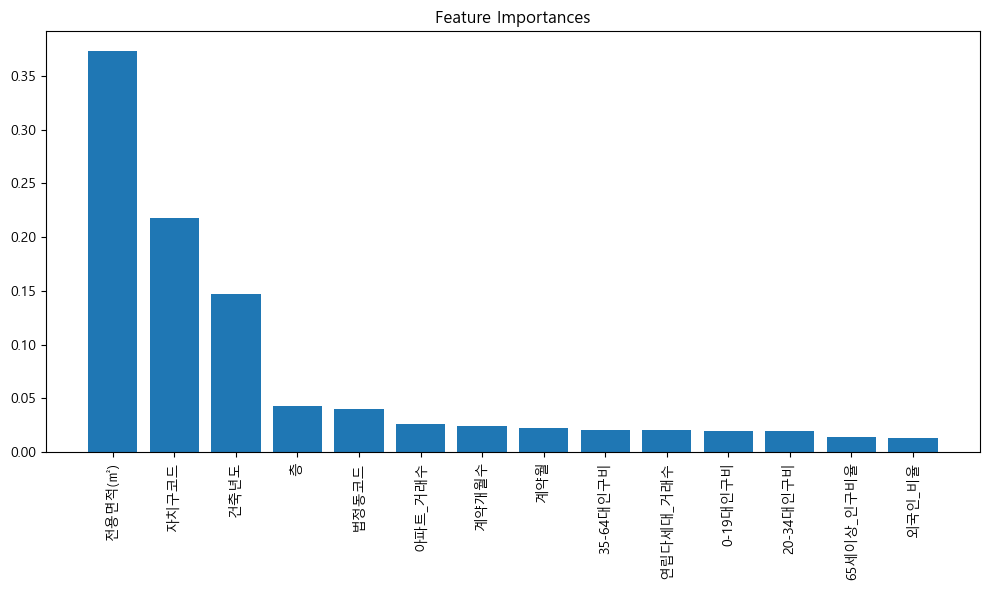

In [30]:
# 빼야하는 것들 다 뺴고 기본적인 것만 남김
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df_type0.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)','주택유형_encoded'] + group_features,axis=1),'월부담액',plot_feature_importance=True,plot_shap=False)

**아래 모델은 각 유형별 한개씩**
즉 hospital의 5개* station*2개 * 3 * 3 * 3 * 4  = 1080개의 조합 중 최고의 성능을 보여주는 상위의 5개 조합을 보여줌.

In [31]:
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# (예시) 각 그룹 변수 리스트 정의
hospital_group = ['병원_10km내_개수', '병원_3km내_개수','병원_0.5km내_개수','병원_1km내_개수','병원_0.2km내_개수']
station_group = ['500m_이내_역_개수', '1km_이내_역_개수']
restaurant_group = ['식당_0.2km내_개수','식당_0.5km내_개수','식당_1km내_개수']
park_group = ['공원_300m_이내_개수','공원_500m_이내_개수','공원_800m_이내_개수']
police_group = ['파출소/지구대_0.5km내_개수','파출소/지구대_1km내_개수','파출소/지구대_3km내_개수']
university_group = ['대학_0.2km내_개수','대학_0.5km내_개수','대학_1km내_개수','대학_2km내_개수']
기본변수리스트 = ['전용면적(㎡)','자치구코드','건축년도','층','법정동코드','아파트_거래수',
'계약개월수','계약월','35-64대인구비','연립다세대_거래수','0-19대인구비','20-34대인구비','65세이상_인구비율','외국인_비율']  # 입지 변수 제외한 주요 변수 리스트

group_lists = [
    hospital_group,
    station_group,
    restaurant_group,
    park_group,
    police_group,
    university_group
]

all_combinations = list(itertools.product(*group_lists))

results = []

for combo in all_combinations:
    feature_list = list(combo)
    cols_to_use = 기본변수리스트 + feature_list
    df_sub = df_type0[cols_to_use].copy()
    df_sub['월부담액'] = df_type0['월부담액']

    # 모델 학습 및 평가 (함수 이용)
    model, (X_train, X_test, y_train, y_test) = train_eval_xgb(
        df_sub,
        target_col='월부담액',
        plot_feature_importance=False,
        plot_shap=False
    )
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({'features': feature_list, 'r2': r2, 'mse': mse})

# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# r2(성능) 기준 내림차순 정렬, 상위 5개 조합 확인
top_results = results_df.sort_values('r2', ascending=False).head()
print(top_results)


Test RMSE: 0.3278
Test MAE: 0.1976
Test R^2: 0.9324
Test RMSE: 0.3285
Test MAE: 0.1969
Test R^2: 0.9322
Test RMSE: 0.3348
Test MAE: 0.1981
Test R^2: 0.9295
Test RMSE: 0.3306
Test MAE: 0.1967
Test R^2: 0.9313
Test RMSE: 0.3337
Test MAE: 0.1991
Test R^2: 0.9300
Test RMSE: 0.3281
Test MAE: 0.1973
Test R^2: 0.9323
Test RMSE: 0.3317
Test MAE: 0.1984
Test R^2: 0.9308
Test RMSE: 0.3334
Test MAE: 0.1992
Test R^2: 0.9301
Test RMSE: 0.3354
Test MAE: 0.1981
Test R^2: 0.9293
Test RMSE: 0.3413
Test MAE: 0.2011
Test R^2: 0.9267
Test RMSE: 0.3359
Test MAE: 0.1999
Test R^2: 0.9291
Test RMSE: 0.3352
Test MAE: 0.1994
Test R^2: 0.9294
Test RMSE: 0.3336
Test MAE: 0.1983
Test R^2: 0.9300
Test RMSE: 0.3320
Test MAE: 0.1967
Test R^2: 0.9307
Test RMSE: 0.3280
Test MAE: 0.1974
Test R^2: 0.9324
Test RMSE: 0.3338
Test MAE: 0.1999
Test R^2: 0.9300
Test RMSE: 0.3375
Test MAE: 0.1991
Test R^2: 0.9284
Test RMSE: 0.3380
Test MAE: 0.2004
Test R^2: 0.9282
Test RMSE: 0.3303
Test MAE: 0.1965
Test R^2: 0.9314
Test RMSE: 0

In [32]:
#  나온 최고의 조합 확인!
for idx, row in top_results.iterrows():
    print(f"features: {row['features']}\nr2: {row['r2']:.4f}, mse: {row['mse']:.4f}\n")


features: ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.5km내_개수', '공원_800m_이내_개수', '파출소/지구대_1km내_개수', '대학_2km내_개수']
r2: 0.9350, mse: 0.3215

features: ['병원_10km내_개수', '500m_이내_역_개수', '식당_0.5km내_개수', '공원_300m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_0.2km내_개수']
r2: 0.9345, mse: 0.3227

features: ['병원_0.2km내_개수', '500m_이내_역_개수', '식당_1km내_개수', '공원_300m_이내_개수', '파출소/지구대_1km내_개수', '대학_0.5km내_개수']
r2: 0.9344, mse: 0.3229

features: ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.5km내_개수', '공원_800m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_0.5km내_개수']
r2: 0.9341, mse: 0.3237

features: ['병원_0.5km내_개수', '1km_이내_역_개수', '식당_0.2km내_개수', '공원_500m_이내_개수', '파출소/지구대_1km내_개수', '대학_0.2km내_개수']
r2: 0.9340, mse: 0.3240



Test RMSE: 0.3211
Test MAE: 0.1940
Test R^2: 0.9352


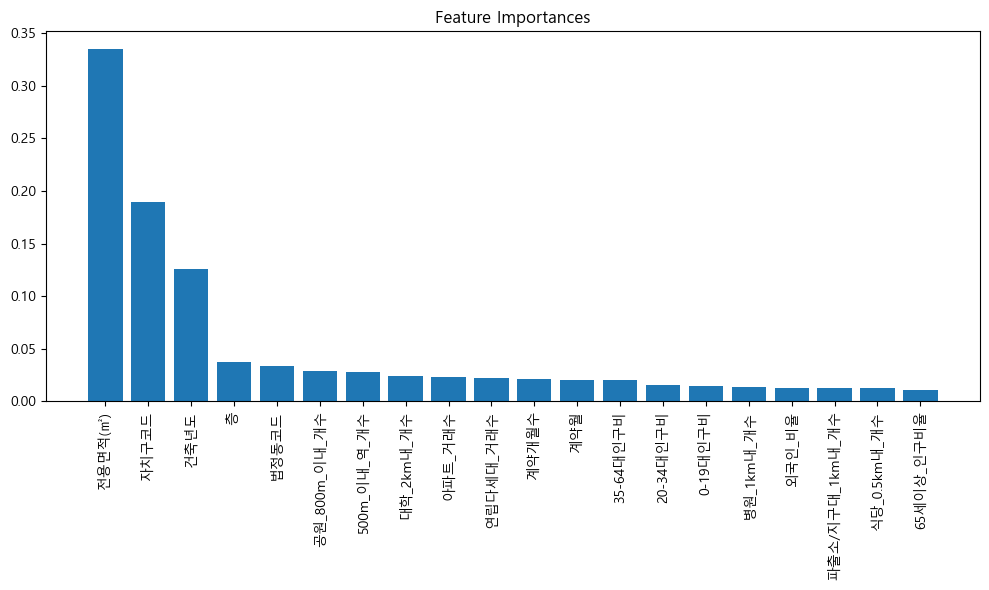

In [33]:
# 아래의 모델을 돌려서 나온 최고의 조합을 넣어서 성능 체크를 해봄(기본 모형보다 모델 성능도 향상)

cols_to_add = ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.5km내_개수', '공원_800m_이내_개수', '파출소/지구대_1km내_개수', '대학_2km내_개수']
X_input = df_type0.drop(['보증금/월세금', '월세금/면적', '월세금(만원)', '보증금(만원)', '주택유형_encoded'] + group_features, axis=1)

X_input[cols_to_add] = df_type0[cols_to_add] 

model, (X_train, X_test, y_train, y_test) = train_eval_xgb(X_input, '월부담액', plot_feature_importance=True, plot_shap=False)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


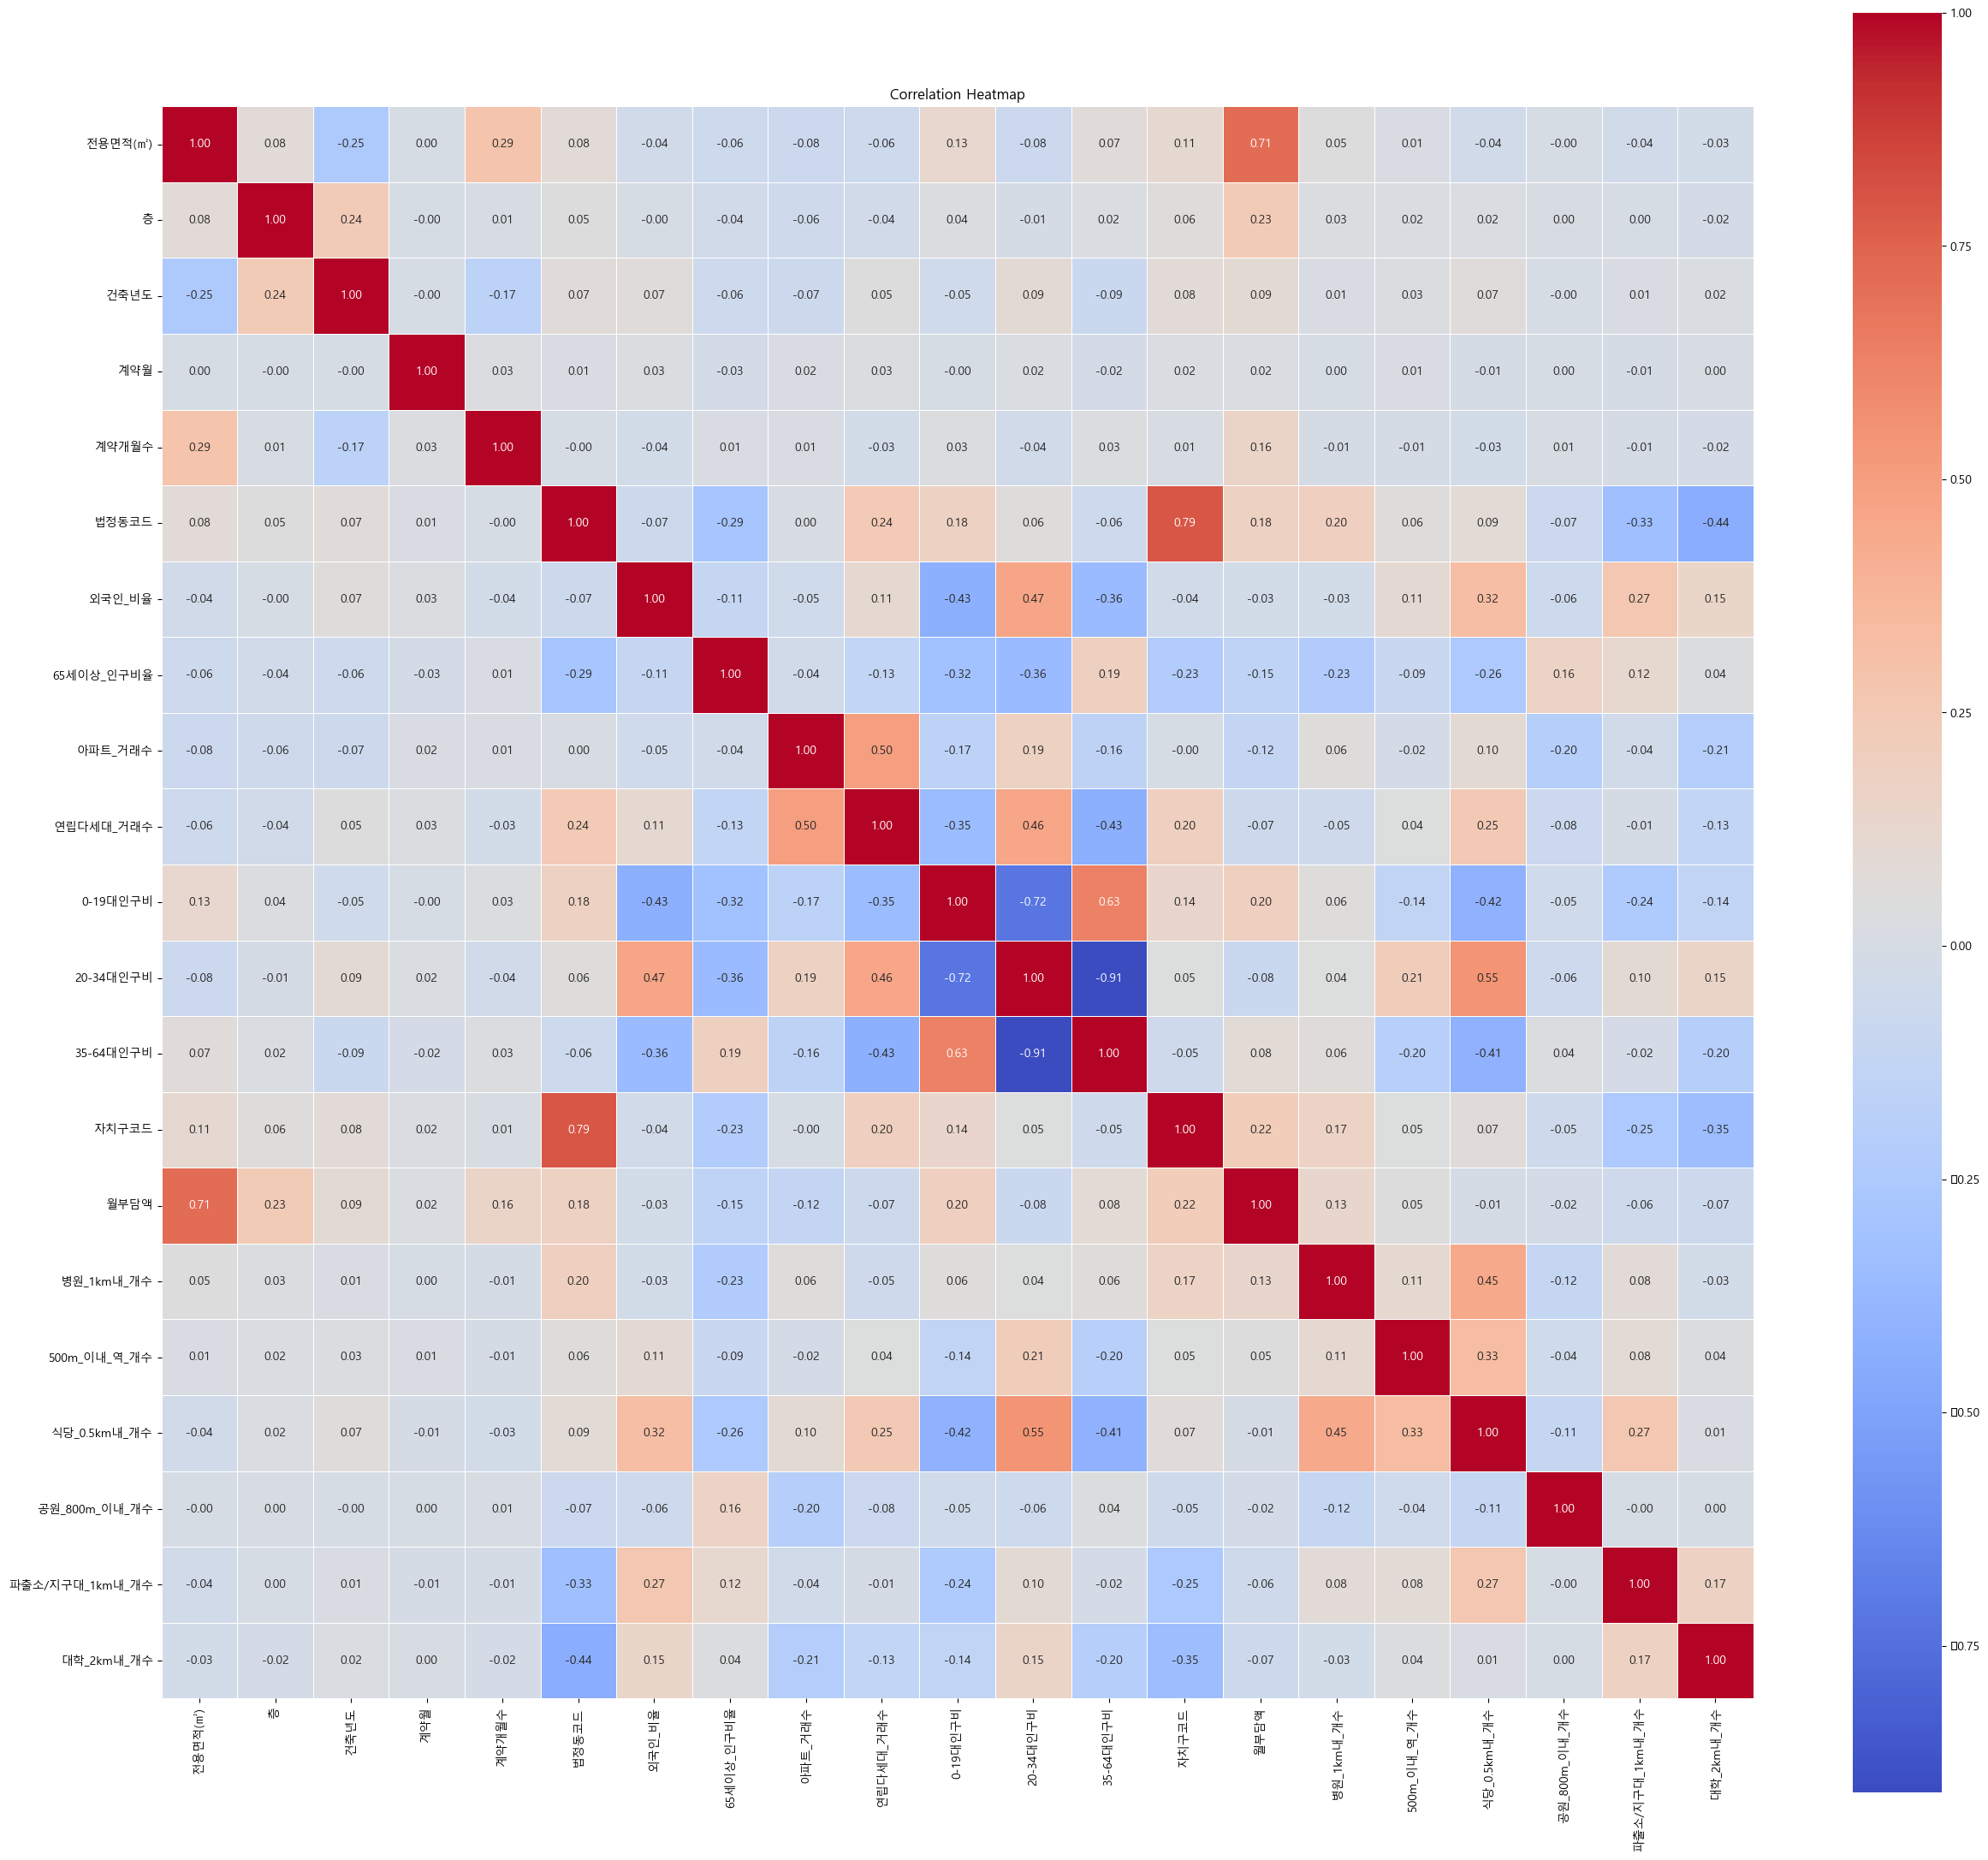

In [34]:

# 1. 숫자 컬럼만 선택
numeric_df = X_input.select_dtypes(include='number')

# 2. 상관관계 행렬 계산
corr = numeric_df.corr()

# 3. 히트맵 시각화
plt.figure(figsize=(30, 27))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

연립다세대에 feature importance 기반 최적의 거리 찾기


Test RMSE: 0.1673
Test MAE: 0.1058
Test R^2: 0.8388


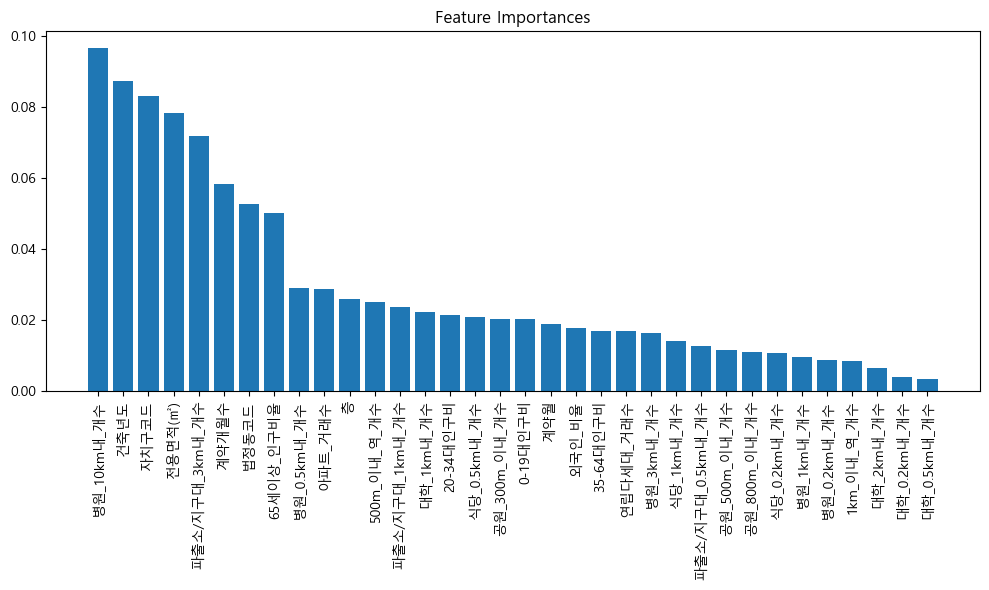

In [35]:
#  연립다세대 모든 유형별 각 거리를 다 넣어봄
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df_type1.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)','주택유형_encoded'],axis=1),'월부담액',plot_feature_importance=True,plot_shap=False)

Test RMSE: 0.1663
Test MAE: 0.1057
Test R^2: 0.8406


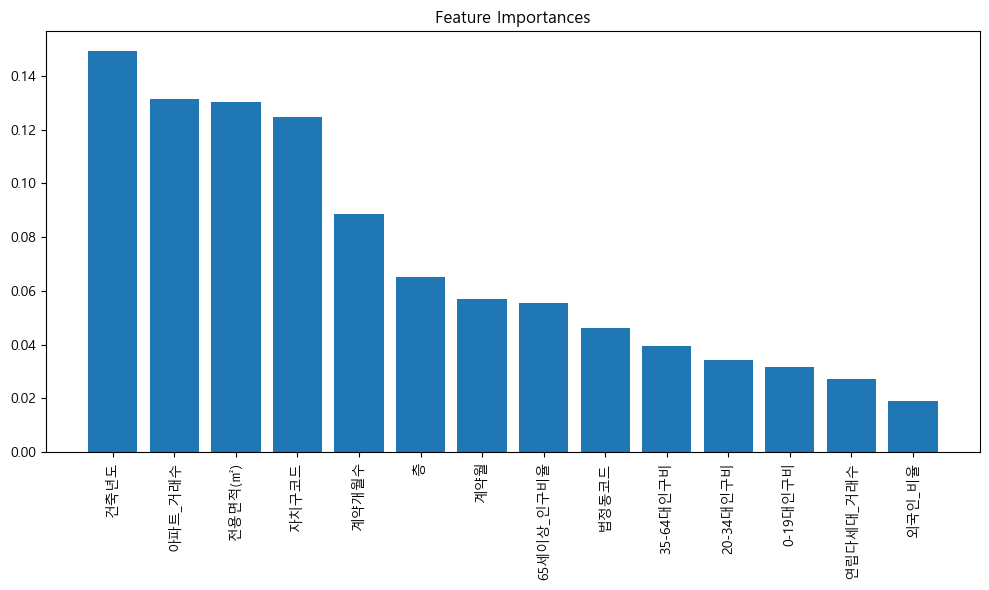

In [36]:
# 연립 다세대 basci model
model, (X_train, X_test, y_train, y_test) = train_eval_xgb(df_type1.drop(['보증금/월세금','월세금/면적','월세금(만원)','보증금(만원)','주택유형_encoded'] + group_features,axis=1),'월부담액',plot_feature_importance=True,plot_shap=False)

In [37]:
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# (예시) 각 그룹 변수 리스트 정의
hospital_group = ['병원_10km내_개수', '병원_3km내_개수','병원_0.5km내_개수','병원_1km내_개수','병원_0.2km내_개수']
station_group = ['500m_이내_역_개수', '1km_이내_역_개수']
restaurant_group = ['식당_0.2km내_개수','식당_0.5km내_개수','식당_1km내_개수']
park_group = ['공원_300m_이내_개수','공원_500m_이내_개수','공원_800m_이내_개수']
police_group = ['파출소/지구대_0.5km내_개수','파출소/지구대_1km내_개수','파출소/지구대_3km내_개수']
university_group = ['대학_0.2km내_개수','대학_0.5km내_개수','대학_1km내_개수','대학_2km내_개수']
기본변수리스트 = ['전용면적(㎡)','자치구코드','건축년도','층','법정동코드','아파트_거래수',
'계약개월수','계약월','35-64대인구비','연립다세대_거래수','0-19대인구비','20-34대인구비','65세이상_인구비율','외국인_비율']  # 입지 변수 제외한 주요 변수 리스트

group_lists = [
    hospital_group,
    station_group,
    restaurant_group,
    park_group,
    police_group,
    university_group
]

all_combinations = list(itertools.product(*group_lists))

results = []

for combo in all_combinations:
    feature_list = list(combo)
    cols_to_use = 기본변수리스트 + feature_list
    df_sub = df_type1[cols_to_use].copy()
    df_sub['월부담액'] = df_type1['월부담액']

    # 모델 학습 및 평가 (함수 이용)
    model, (X_train, X_test, y_train, y_test) = train_eval_xgb(
        df_sub,
        target_col='월부담액',
        plot_feature_importance=False,
        plot_shap=False
    )
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    results.append({'features': feature_list, 'r2': r2, 'rmse': rmse})

# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# r2(성능) 기준 내림차순 정렬, 상위 5개 조합 확인
top_results = results_df.sort_values('r2', ascending=False).head()
print(top_results)

Test RMSE: 0.1633
Test MAE: 0.1056
Test R^2: 0.8464
Test RMSE: 0.1664
Test MAE: 0.1062
Test R^2: 0.8406
Test RMSE: 0.1640
Test MAE: 0.1055
Test R^2: 0.8450
Test RMSE: 0.1633
Test MAE: 0.1056
Test R^2: 0.8464
Test RMSE: 0.1644
Test MAE: 0.1060
Test R^2: 0.8443
Test RMSE: 0.1641
Test MAE: 0.1057
Test R^2: 0.8449
Test RMSE: 0.1648
Test MAE: 0.1054
Test R^2: 0.8435
Test RMSE: 0.1653
Test MAE: 0.1059
Test R^2: 0.8427
Test RMSE: 0.1637
Test MAE: 0.1055
Test R^2: 0.8456
Test RMSE: 0.1647
Test MAE: 0.1058
Test R^2: 0.8437
Test RMSE: 0.1635
Test MAE: 0.1058
Test R^2: 0.8460
Test RMSE: 0.1620
Test MAE: 0.1053
Test R^2: 0.8489
Test RMSE: 0.1636
Test MAE: 0.1054
Test R^2: 0.8459
Test RMSE: 0.1659
Test MAE: 0.1060
Test R^2: 0.8414
Test RMSE: 0.1643
Test MAE: 0.1052
Test R^2: 0.8445
Test RMSE: 0.1642
Test MAE: 0.1054
Test R^2: 0.8448
Test RMSE: 0.1640
Test MAE: 0.1059
Test R^2: 0.8452
Test RMSE: 0.1614
Test MAE: 0.1050
Test R^2: 0.8500
Test RMSE: 0.1625
Test MAE: 0.1053
Test R^2: 0.8479
Test RMSE: 0

In [38]:
#  나온 최고의 조합 확인!
for idx, row in top_results.iterrows():
    print(f"features: {row['features']}\nr2: {row['r2']:.4f}, rmse: {row['rmse']:.4f}\n")

features: ['병원_1km내_개수', '1km_이내_역_개수', '식당_0.5km내_개수', '공원_500m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_1km내_개수']
r2: 0.8523, rmse: 0.1602

features: ['병원_1km내_개수', '1km_이내_역_개수', '식당_0.5km내_개수', '공원_800m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_1km내_개수']
r2: 0.8521, rmse: 0.1603

features: ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.2km내_개수', '공원_500m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_1km내_개수']
r2: 0.8516, rmse: 0.1605

features: ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.2km내_개수', '공원_800m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_1km내_개수']
r2: 0.8513, rmse: 0.1607

features: ['병원_1km내_개수', '500m_이내_역_개수', '식당_0.2km내_개수', '공원_800m_이내_개수', '파출소/지구대_3km내_개수', '대학_1km내_개수']
r2: 0.8512, rmse: 0.1608



Test RMSE: 0.1599
Test MAE: 0.1050
Test R^2: 0.8528


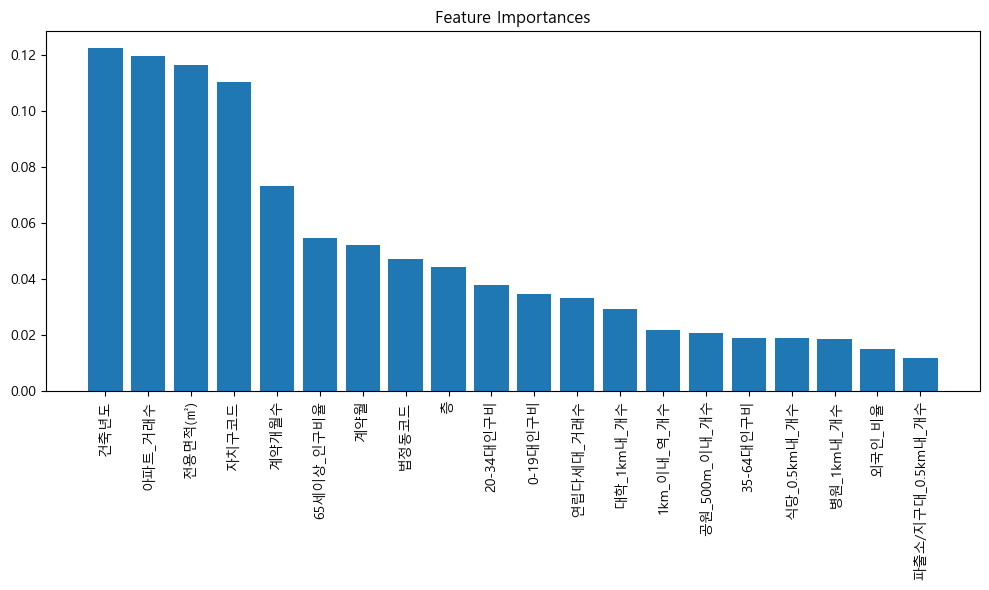

In [39]:
cols_to_add = ['병원_1km내_개수', '1km_이내_역_개수', '식당_0.5km내_개수', '공원_500m_이내_개수', '파출소/지구대_0.5km내_개수', '대학_1km내_개수']
X_input = df_type1.drop(['보증금/월세금', '월세금/면적', '월세금(만원)', '보증금(만원)', '주택유형_encoded'] + group_features, axis=1)

X_input[cols_to_add] = df_type1[cols_to_add] 

model, (X_train, X_test, y_train, y_test) = train_eval_xgb(X_input, '월부담액', plot_feature_importance=True, plot_shap=False)

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


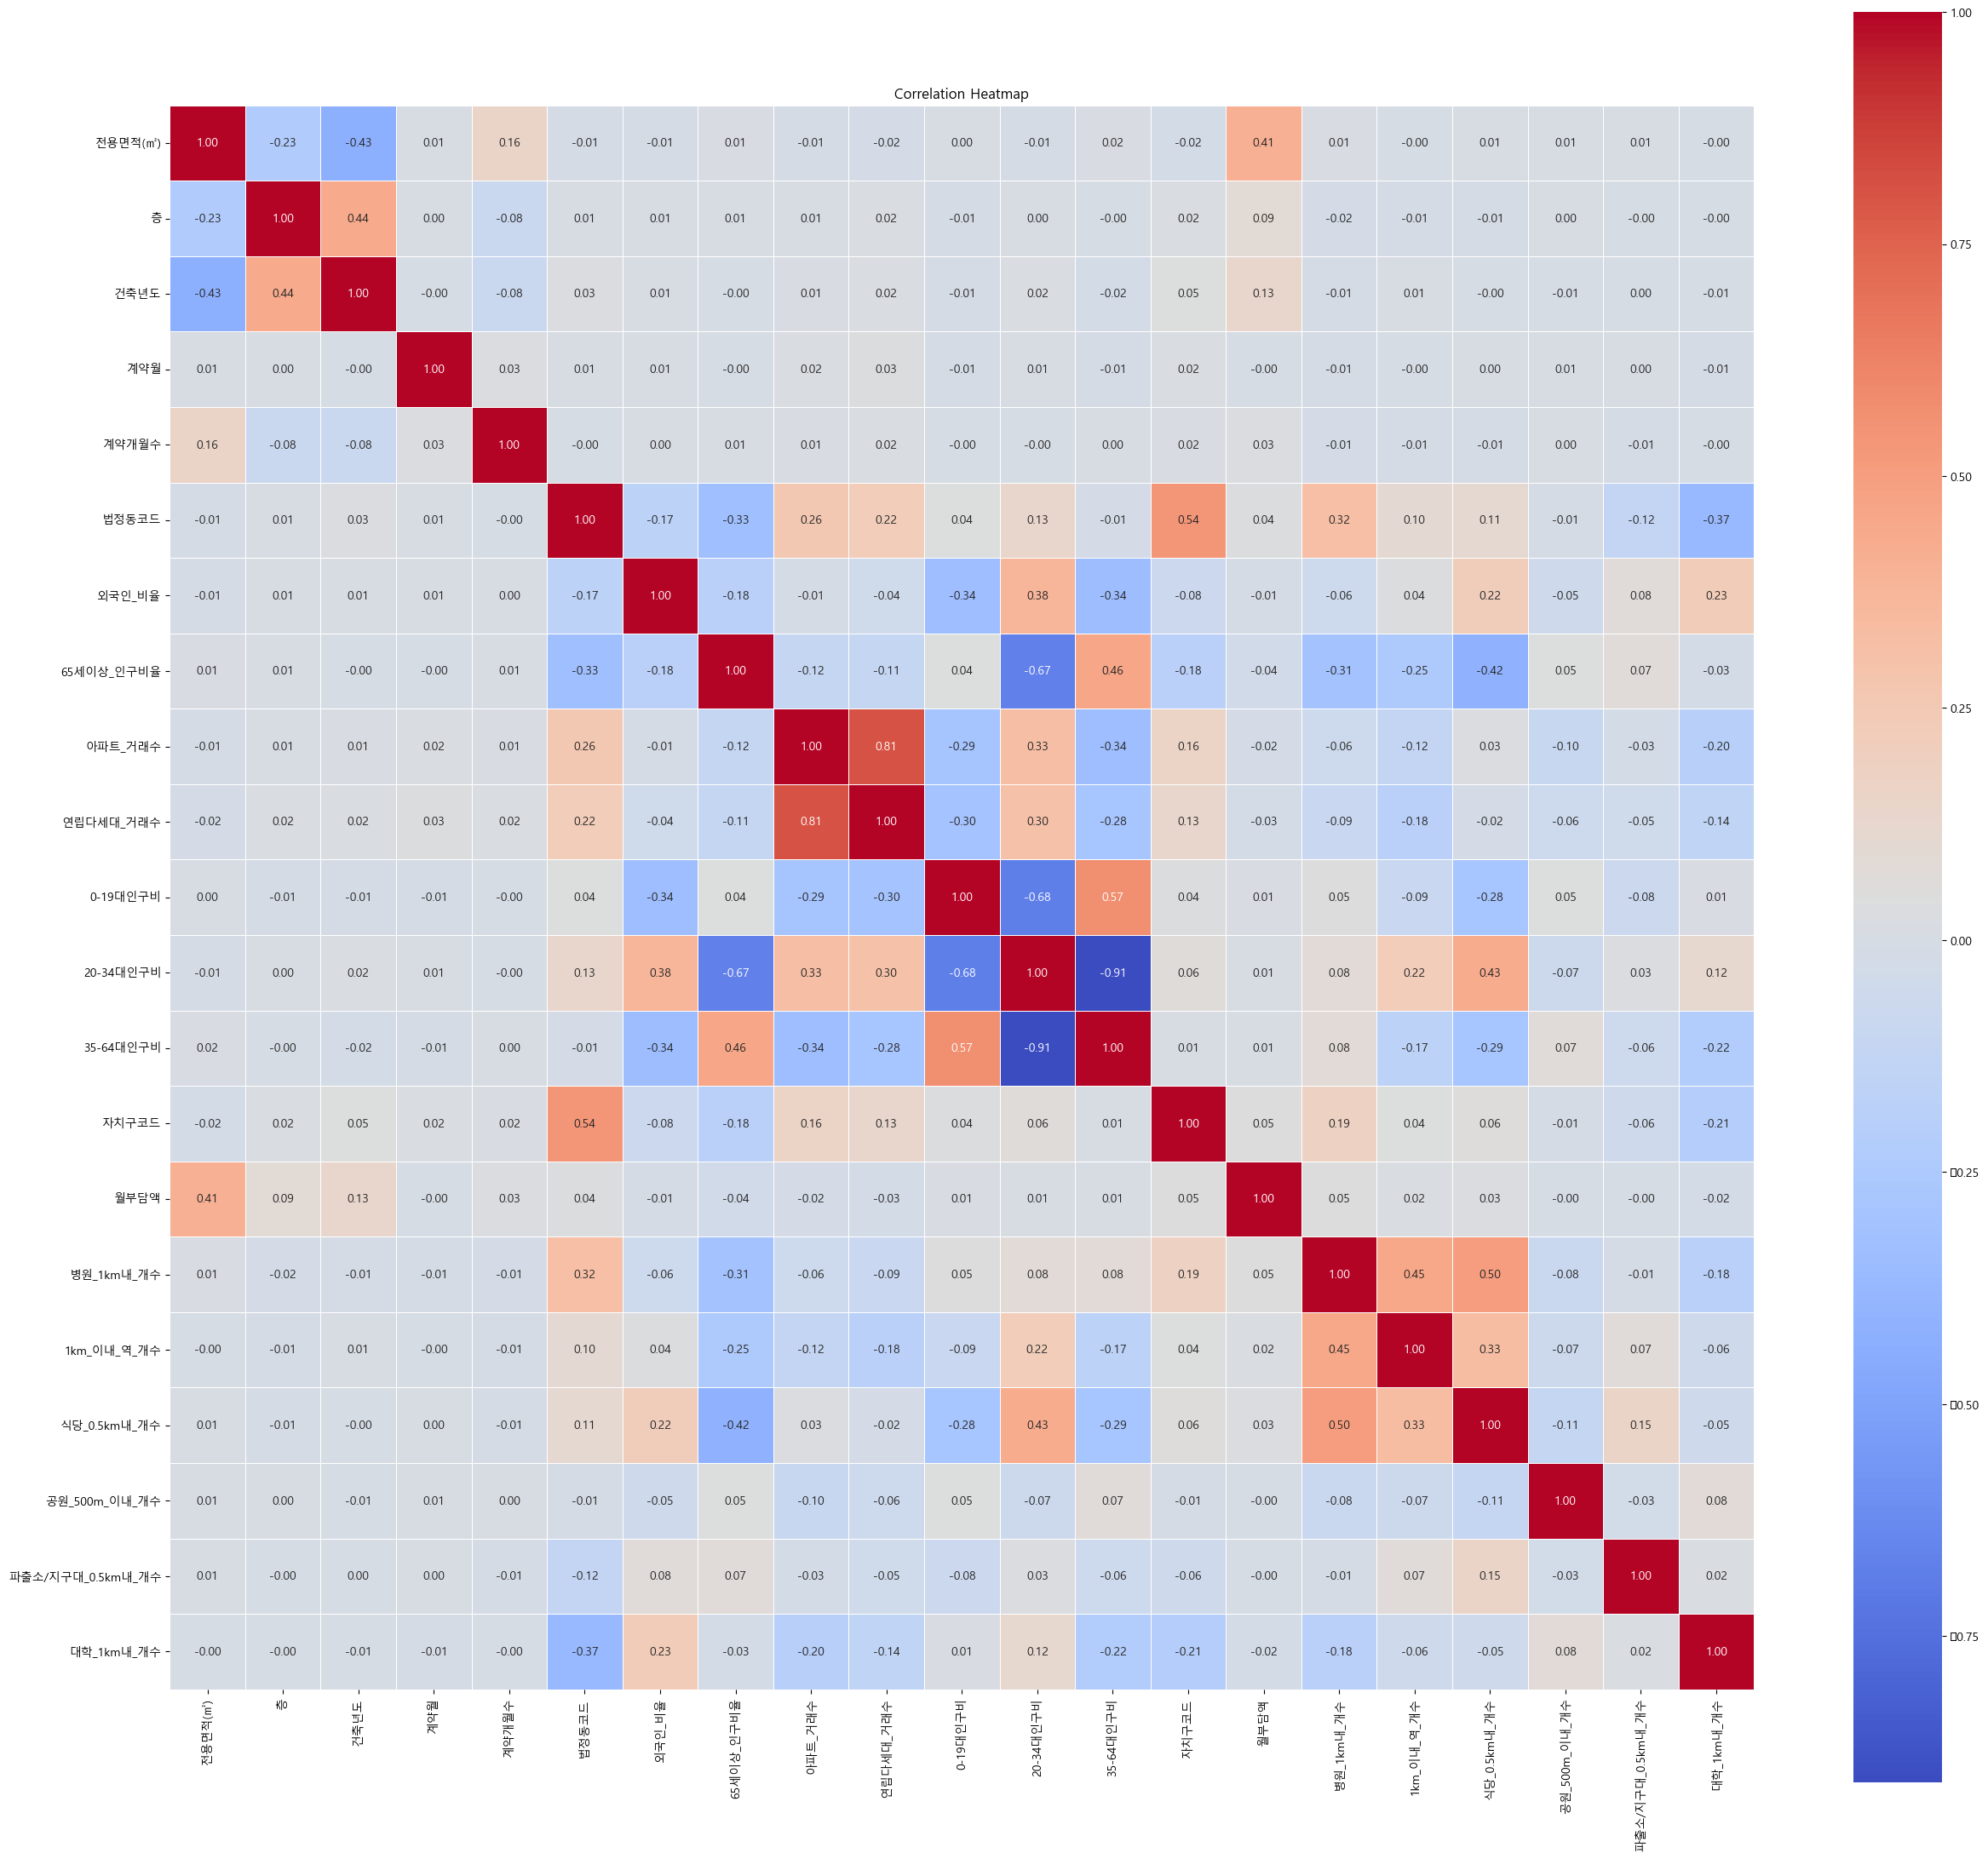

In [40]:

# 1. 숫자 컬럼만 선택
numeric_df = X_input.select_dtypes(include='number')

# 2. 상관관계 행렬 계산
corr = numeric_df.corr()

# 3. 히트맵 시각화
plt.figure(figsize=(30, 27))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()